In [7]:
from jax.config import config
config.update('jax_enable_x64', True)
import jax.numpy as jnp
from exoplanet_core import kepler
from jax import grad, jit
from exoplanet_core import quad_limbdark_light_curve
import matplotlib.pyplot as plt

In [63]:
N = 500
M = jnp.linspace(-jnp.pi, jnp.pi, N)
ecc = 0.2
u1, u2 = 0.3, 0.2
ror = 0.05
b = jnp.sqrt(jnp.linspace(-3, 3, N)**2 + 0.1**2)
flux_obs = quad_limbdark_light_curve(u1, u2, b, ror)

In [64]:
from exoplanet_core.jax import ops
def flux_model(b, u1, u2, ror):
    rarr = b / b * ror
    soln = ops.quad_solution_vector(b, rarr)
    g = jnp.array([1.-u1-1.5*u2, u1+2*u2, -0.25*u2])
    I0 = jnp.pi * (g[0] + 2*g[1]/3.)
    return jnp.dot(soln, g) / I0 - 1.

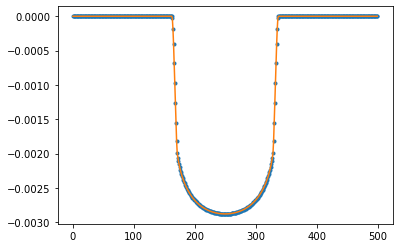

In [65]:
plt.plot(flux_obs, '.')
plt.plot(flux_model(b,u1,u2,ror))

In [66]:
from numpyro.infer import init_to_value
import numpyro.distributions as dist
import jax.random as random
import numpyro

def model(fobs, sigma):
    u1 = numpyro.sample("u1", dist.Normal())
    u2 = numpyro.sample("u2", dist.Normal())
    lnror = numpyro.sample("lnror", dist.Uniform(low=-5, high=0))
    ror = numpyro.deterministic("ror", jnp.exp(lnror))
    b = numpyro.sample("b", dist.Uniform(low=0, high=1))
    barr = jnp.sqrt(jnp.linspace(-3, 3, N)**2 + b**2)
    model = numpyro.deterministic("model", flux_model(barr, u1, u2, ror))
    numpyro.sample("obs", dist.Normal(loc=model, scale=sigma), obs=fobs)

In [67]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9)

In [68]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=1000, num_samples=1000)

In [69]:
from jax import random
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, flux_obs, 1e-4)

sample: 100%|████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 483.98it/s, 31 steps of size 1.17e-01. acc. prob=0.95]


In [70]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      0.09      0.03      0.09      0.05      0.13    172.76      1.02
     lnror     -3.00      0.00     -3.00     -3.00     -2.99    352.89      1.00
        u1      0.29      0.05      0.29      0.22      0.37    177.80      1.01
        u2      0.22      0.09      0.22      0.07      0.35    172.42      1.01

Number of divergences: 0


In [71]:
models = mcmc.get_samples()['model']

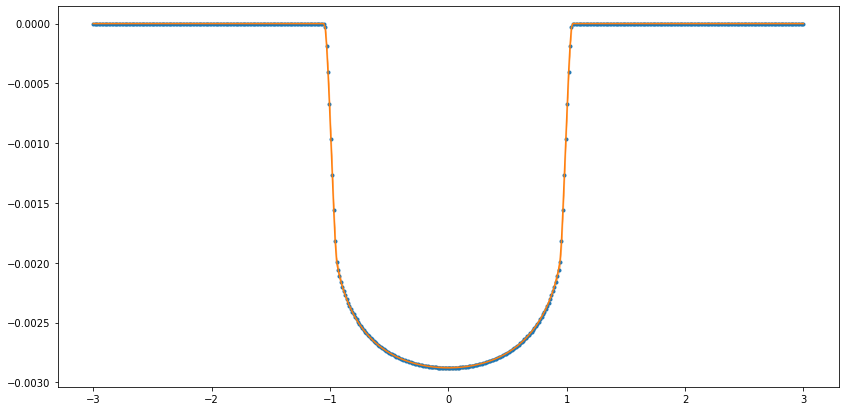

In [75]:
t = jnp.linspace(-3, 3, N)
plt.figure(figsize=(14,7))
plt.plot(t, flux_obs, '.')
m, s = jnp.mean(models, axis=0), jnp.std(models, axis=0)
plt.plot(t, m)
plt.fill_between(t, m-s, m+s, alpha=0.4, color='C1')